# Final Group Assignment
- Analyzing news articles to determine if they are fake or real, using a dataset from kaggle.

### 1. Analysis: Frame the problem and look at the big picture
2. Define the objective in business terms: Create a model capable of recognizing fake and real news.
3. How should you frame the problem (supervised/unsupervised etc.)?: Supervised learning, with binary labeling (1 for real, 0 for fake news) 
4. How should performance be measured?: Performance will be measured by the model accuracy, correctly classified vs. all.

In [23]:
#imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from keras.layers import Embedding, Flatten, Dense
from gensim.models import Word2Vec

### 2. Get the data
Data were retrieved from Kaggle (link below). This data set consists of 2 csv files, one with the real and other with the real news. Both data sets have 'Title', 'Text', 'Subject' and 'Date' columns. 

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In the next step we labeled fake and real data, with 0 and 1 respectively and then merged them into 1 dataframe and shuffled them.

In [6]:
#Load & label fake news data
df_fake = pd.read_csv('Fake.csv')
df_fake['label'] = 0

In [7]:
#Load & label real news data
df_true = pd.read_csv('True.csv')
df_true['label'] = 1
#rename all 'politicsNews' to 'politics' in df_true
df_true['subject'] = df_true['subject'].replace('politicsNews', 'politics')

In [8]:
#print distinct subjects
print(df_fake['subject'].unique())
print(df_true['subject'].unique())

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
['politics' 'worldnews']


In [9]:
#merge & shuffle data
df_news = pd.concat([df_fake, df_true]).sample(frac=1).reset_index(drop=True)
df_news.head()

,title,text,subject,date,label
0,MAINE GOVERNOR: Prove I’m Racist You ‘Socialis...,Maine Governor Paul LePage calls out a liberal...,politics,"Aug 26, 2016",0
1,Key U.S. Republican: Flynn situation adds 'mom...,WASHINGTON (Reuters) - A senior U.S. Senate Re...,politics,"February 14, 2017",1
2,Donald Trump Terrorizes His Fans: ‘Lock Your ...,"On Monday, it seemed that Donald Trump has giv...",News,"April 26, 2016",0
3,"Unlocking iPhone would leave millions exposed,...",WASHINGTON (Reuters) - Unlocking an iPhone use...,politics,"February 29, 2016",1
4,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,politics,"January 28, 2017",1


# 3. Explore and visualise the data to gain insights

# Visualization

In [10]:
#group data by subject and label
df_news.groupby(['subject', 'label']).size()

subject          label
Government News  0         1570
Middle-east      0          778
News             0         9050
US_News          0          783
left-news        0         4459
politics         0         6841
                 1        11272
worldnews        1        10145
dtype: int64

label
0    23481
1    21417
dtype: int64


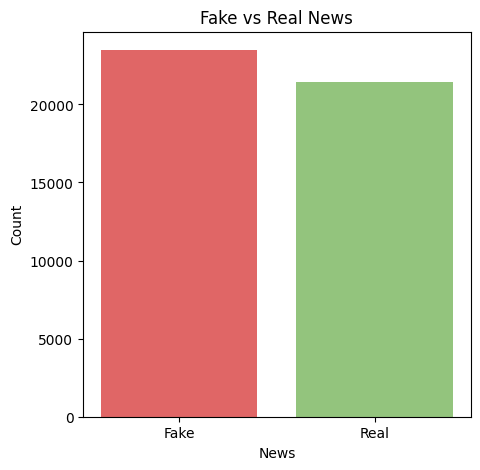

In [11]:
#fake vs real news
print(df_news.groupby(['label']).size())

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.bar(df_news['label'].unique(), df_news.groupby(['label']).size(), color=['#e06666','#93c47d'])
plt.xticks(df_news['label'].unique(), ['Fake', 'Real'])
plt.xlabel('News')
plt.ylabel('Count')
plt.title('Fake vs Real News')
plt.show()

<Axes: xlabel='subject'>

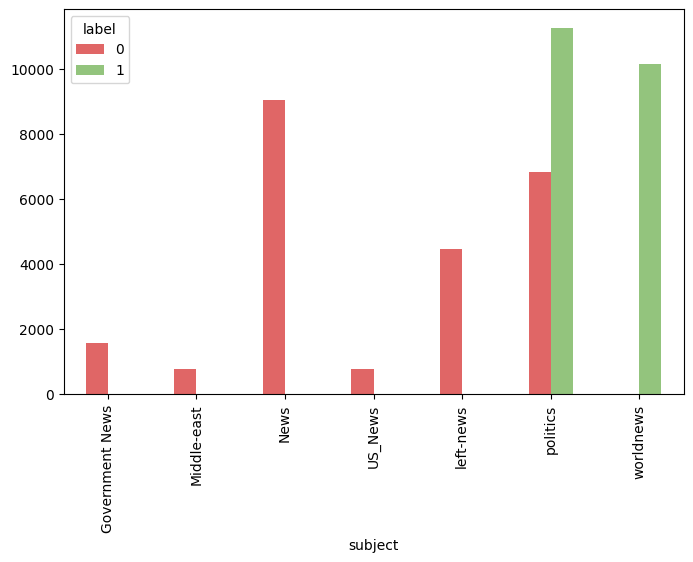

In [12]:
#number of articles per subject and label
df_news.groupby(['subject', 'label']).size().unstack().plot(kind='bar', color=['#e06666','#93c47d'], stacked=False, figsize=(8, 5))

In [13]:
#print the full text of the first 5 articles of subject 'worldnews'
for i in range(5):
    print(df_news[(df_news['subject'] == 'worldnews') & (df_news['label'] == 1)]['text'].iloc[i])
    print('---------------------------------')

PARIS (Reuters) - France s foreign ministry said on Tuesday that it picked its former ambassador to Saudi Arabia as a special envoy to see how Paris could support mediation efforts in the rift between Qatar and several of its neighbors. Kuwait s Emir Sheikh Sabah al-Ahmad al-Jaber has led mediation efforts to resolve the row, which began in early June when Saudi Arabia, Bahrain, the United Arab Emirates and Egypt cut political and trade ties with Qatar.  France, which has close ties with Egypt and the United Arab Emirates while also being a major arms supplier to Qatar and a key ally of Saudi Arabia, has been relatively discreet on the crisis, largely sticking to calls for calm.   I confirm that Bertrand Besancenot, diplomatic advisor to the government, will soon go to the region to evaluate the situation and the best ways to support the mediation and appease tensions between Qatar and its neighbors,  Foreign ministry spokeswoman Agnes Romatet-Espagne told reporters in a daily briefing

label
0    423.197905
1    385.640099
Name: text, dtype: float64


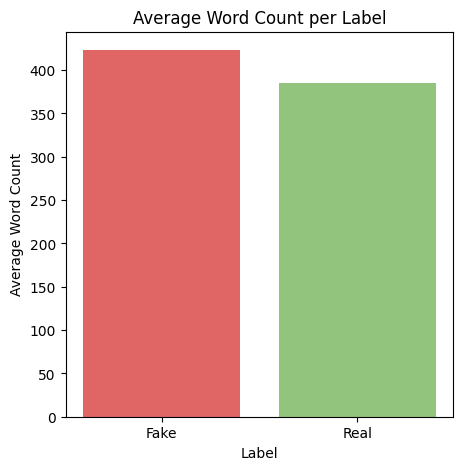

In [14]:
#average word count of articles per label
import matplotlib.pyplot as plt

print(df_news.groupby(['label'])['text'].apply(lambda x: x.str.split().str.len().mean()))
plt.figure(figsize=(5,5))
plt.bar(df_news['label'].unique(), df_news.groupby(['label'])['text'].apply(lambda x: x.str.split().str.len().mean()), color=['#e06666','#93c47d'])
plt.title('Average Word Count per Label')
plt.ylabel('Average Word Count')
plt.xlabel('Label')
plt.xticks(np.arange(2), ('Fake', 'Real'), rotation=0)
plt.show()

<Axes: xlabel='subject'>

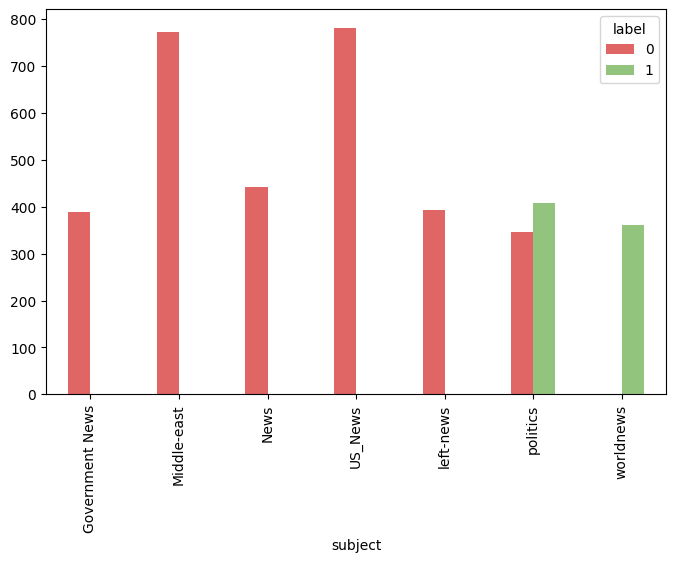

In [15]:
#average word count of articles per subject per label
df_news.groupby(['subject', 'label'])['text'].apply(lambda x: x.str.split().str.len().mean()).unstack().plot(kind='bar', color=['#e06666','#93c47d'], figsize=(8, 5))

# Correlation

<Axes: xlabel='date'>

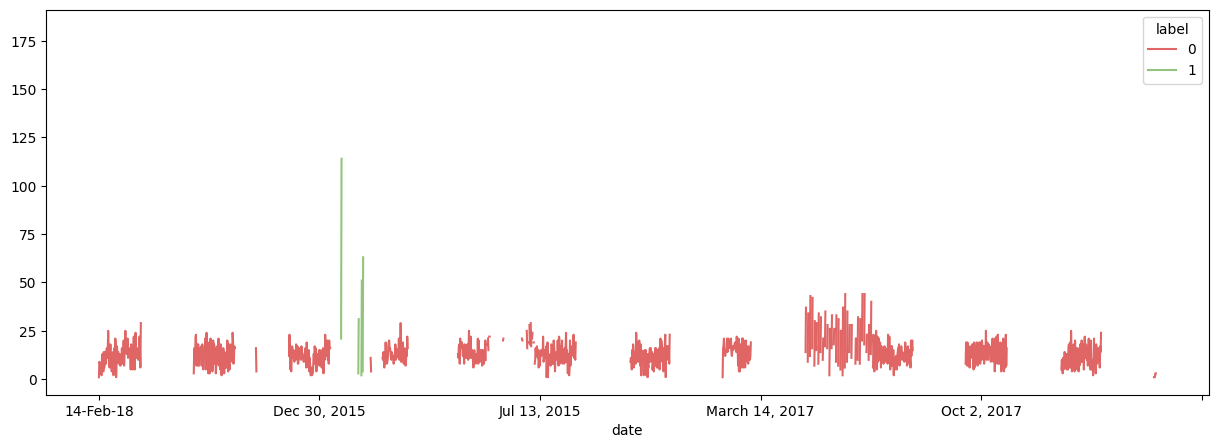

In [16]:
#correlation between date and label
df_news.groupby(['date', 'label']).size().unstack().plot(kind='line', color=['#e06666','#93c47d'], figsize=(15, 5), label=['Fake', 'Real'])

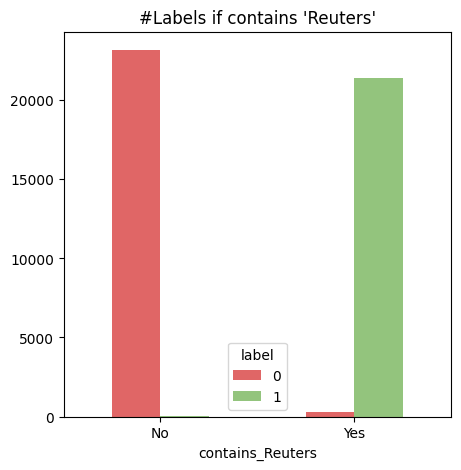

In [17]:
#add column 'contains_Reuters' that will be 1 if the article contains the word 'Reuters' and 0 otherwise
df_news['contains_Reuters'] = df_news['text'].apply(lambda x: 1 if 'Reuters' in x else 0)

#correlation between label and 'contains_Reuters'
df_news.groupby(['contains_Reuters', 'label']).size().unstack().plot(
    kind='bar',
    color=['#e06666','#93c47d'],
    title="#Labels if contains 'Reuters'",
    figsize=(5, 5),
    ).set_xticklabels(['No', 'Yes'], rotation=0)

#remove contains_Reuters column
df_news.drop(['contains_Reuters'], axis=1, inplace=True)

- The plot above shows the correlation between the authenticity of the news and whether the news agency Reuters appears as a source or not, which we noticed while taking a first glance at the data.
- This is self-explanatory, since Reuters is a reliable source of information.
- There are a few outliers where the news are fake even if 'Reuters' appears in the text or is cited as the source, but the text overall probably contains half true information.

In [18]:
#count how many articles contain the word 'Reuters' in the title
print(df_news['title'].apply(lambda x: 1 if 'Reuters' in x else 0).sum())

#count how many articles contain the word 'Reuters' in the text
print(df_news['text'].apply(lambda x: 1 if 'Reuters' in x else 0).sum())

137
21689


In [19]:
#remove REUTERS, Reuters, reuters from text
df_news['text'] = df_news['text'].apply(lambda x: x.replace('REUTERS', ''))
df_news['text'] = df_news['text'].apply(lambda x: x.replace('Reuters', ''))
df_news['text'] = df_news['text'].apply(lambda x: x.replace('reuters', ''))

#remove REUTERS, Reuters, reuters from title
df_news['title'] = df_news['title'].apply(lambda x: x.replace('REUTERS', ''))
df_news['title'] = df_news['title'].apply(lambda x: x.replace('Reuters', ''))
df_news['title'] = df_news['title'].apply(lambda x: x.replace('reuters', ''))

# 4. Prepare the data

- function for transforming text data: TF-IDF (Term Frequency - Inverse Document Frequency) 
- splitting the data including training, testing and validation sets
- using only title and text on the X variable
- labels will be the label column (0 or 1, namely fake or real)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def transform_with_tfidf(X_train, X_val, X_test,max_df=0.6, max_features=None):
    """
    Transform input data using TfidfVectorizer.

    Parameters:
    - X_train: Training data
    - X_val: Validation data
    - X_test: Test data
    - max_df: Maximum document frequency for TfidfVectorizer

    Returns:
    - X_train_tfidf: Transformed training data
    - X_val_tfidf: Transformed validation data
    - X_test_tfidf: Transformed test data
    """

    if max_features:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=max_df, max_features=max_features)
    else:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=max_df)

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    vectorizer = tfidf_vectorizer

    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer

In [21]:
X = df_news['title'] + ' ' + df_news['text']
y = df_news['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 5. Short-list promising models
- we are sorting them by the method we are using to transform the text:
   - for TF-IDF: Multinomial Naive Bayes and K Nearest Neighbors as classifiers, Logistic Regression and, a Convolutional Neural Network
   - for Word2Vec: A simple neural network with default parameters

## I. TF-IDF

In [18]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer = transform_with_tfidf(X_train, X_val, X_test, max_df=0.6)

### a) Multinomial naive bayes 

In [20]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

y_val_pred = clf.predict(X_val_tfidf)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')

print(classification_report(y_test, y_pred))


Accuracy: 0.94
Validation Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2394
           1       0.93      0.93      0.93      2096

    accuracy                           0.94      4490
   macro avg       0.94      0.94      0.94      4490
weighted avg       0.94      0.94      0.94      4490



### b) KNN with an arbitrary number of neighbors

In [21]:
knn_classifier = KNeighborsClassifier(n_neighbors=5) 
knn_classifier.fit(X_train_tfidf, y_train)

y_pred = knn_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Test Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2394
           1       0.81      0.93      0.87      2096

    accuracy                           0.87      4490
   macro avg       0.87      0.87      0.87      4490
weighted avg       0.88      0.87      0.87      4490



### c) Convolutional Neural Network

In [29]:
#CNN
from tensorflow import keras

X_train_tfidf, X_val_tfidf, X_test_tfidf, cnn_vectorizer = transform_with_tfidf(X_train, X_val, X_test, max_df=0.6, max_features=5000)

cnn_model = keras.Sequential([
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4996, 128)         768       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2498, 128)         0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 319744)            0         
                                                                 
 dense_2 (Dense)             (None, 10)                3197450   
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3198229 (12.20 MB)
Trainable params: 3198229 (12.20 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [30]:
#print type of X_train_tfidf
print(type(X_train_tfidf))

#count number of vectors in first row of X_train_tfidf
print(len(X_train_tfidf[0].data))
print(len(X_train_tfidf[1].data))
print(len(X_train_tfidf[2].data))
print(len(X_train_tfidf[-2].data))

<class 'scipy.sparse._csr.csr_matrix'>
114
169
136
128


In [31]:
print(X_train_tfidf[-2].shape)
print(X_train_tfidf[-2].data)

(1, 5000)
[0.0813864  0.07349693 0.07901555 0.06864237 0.07371471 0.06877262
 0.07972831 0.07736112 0.08155273 0.05687151 0.07209072 0.06608904
 0.06939748 0.07492752 0.06356284 0.07727937 0.05742864 0.18003625
 0.06582303 0.05840089 0.07510003 0.05149924 0.07195226 0.07732018
 0.10551457 0.06709219 0.04917704 0.06960457 0.06979134 0.06690075
 0.04908431 0.1879697  0.10156545 0.04834491 0.05995191 0.0520306
 0.06149667 0.06786561 0.05894081 0.0726301  0.06807121 0.0503027
 0.04429511 0.05157917 0.0584621  0.07304168 0.0469899  0.13496664
 0.05070154 0.16703669 0.08449432 0.04782026 0.14314379 0.0355745
 0.07740217 0.04713594 0.06002054 0.03809679 0.04629485 0.05698113
 0.06007799 0.04778288 0.04589505 0.04859024 0.14119481 0.04450986
 0.09333599 0.04609142 0.05303582 0.04974709 0.05145028 0.04940641
 0.0347441  0.03279749 0.03294569 0.32402418 0.0607386  0.0383791
 0.04409081 0.07091804 0.05048927 0.04286362 0.11105938 0.05154222
 0.04960233 0.08525034 0.04488553 0.1097499  0.03678769 

Epoch 1/10
281/281 [==============================] - 234s 830ms/step - loss: 0.1588 - accuracy: 0.9429 - val_loss: 0.0713 - val_accuracy: 0.9748
Epoch 2/10
281/281 [==============================] - 267s 950ms/step - loss: 0.0516 - accuracy: 0.9821 - val_loss: 0.0617 - val_accuracy: 0.9788
Epoch 3/10
281/281 [==============================] - 243s 864ms/step - loss: 0.0345 - accuracy: 0.9886 - val_loss: 0.0747 - val_accuracy: 0.9724
Epoch 4/10
281/281 [==============================] - 226s 806ms/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.0617 - val_accuracy: 0.9793
Epoch 5/10
281/281 [==============================] - 234s 832ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.0710 - val_accuracy: 0.9788
Epoch 6/10
281/281 [==============================] - 227s 806ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0724 - val_accuracy: 0.9806
Epoch 7/10
281/281 [==============================] - 229s 814ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.0817 -

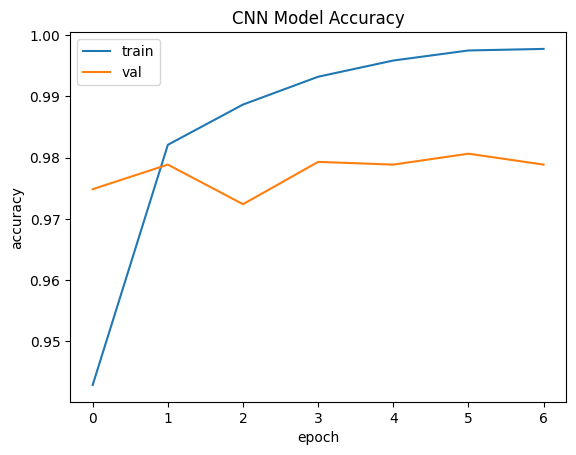

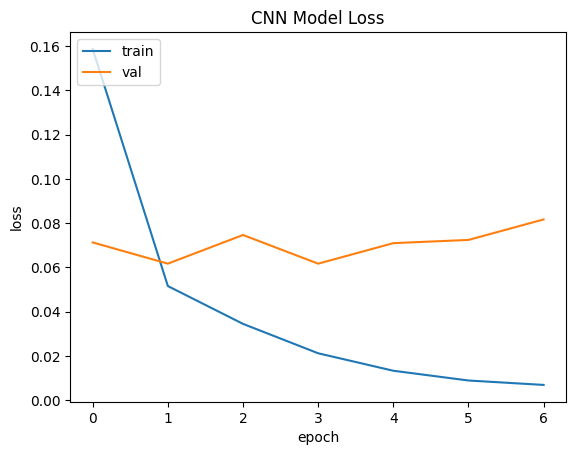

In [32]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X_train_tfidf_arr = X_train_tfidf.toarray()
X_val_tfidf_arr = X_val_tfidf.toarray()

history = cnn_model.fit(X_train_tfidf_arr, y_train, epochs=10, batch_size=128, validation_data=(X_val_tfidf_arr, y_val), callbacks=[es])

#plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
#evaluate model on test data
X_test_tfidf_arr = X_test_tfidf.toarray()

test_loss, test_acc = cnn_model.evaluate(X_test_tfidf_arr, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.2f}')

141/141 - 9s - loss: 0.0626 - accuracy: 0.9813 - 9s/epoch - 61ms/step
Test accuracy: 0.98


### d) Logistic regression

In [34]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.98


<Axes: >

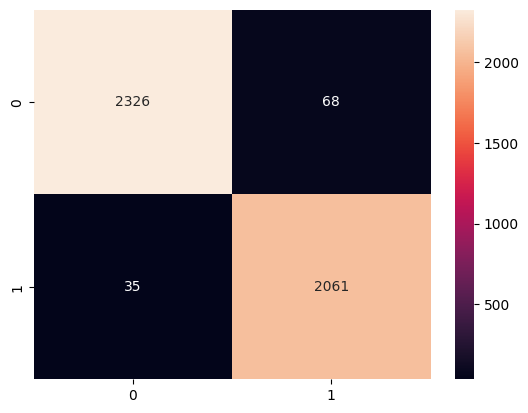

In [35]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [36]:
#print one of the misclassified articles
print(X_test[y_test != y_pred].iloc[1])

'It's made in Vietnam!' At inauguration, origin of red Trump hats shocks many WASHINGTON () - One of the biggest cheers President Donald Trump received from supporters watching his inaugural address on Friday was his call to “buy American and hire American.”  It was a moment rich in irony. Many of those supporters were sporting Trump’s trademark red “Make America Great Again” baseball caps that were made in China, Vietnam and Bangladesh. Some were horrified when they discovered their Trump hats were foreign made.  Rob Walker, 44, who had driven to Washington from Georgia with his wife Abby, 36, had stopped at a truck stop on the way to buy a “Make America Great Again” cap. “Oh God, I hope it’s not made in China,” Abby said, flipping the cap over to check. She looked at its label. “China! Don’t tell anyone!” The Trump hats available for purchase on Trump’s official campaign website are made in the United States and cost between $25 and $30, according to the label inside those caps.  But

## II) Using WordEmbeddings for text representation (Word2Vec) and a simple neural network

In [46]:
X = df_news['title'] + ' ' + df_news['text']
y = df_news['label']

# Convert labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
max_words = 100000  # Adjust based on the size of your vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length for input to neural network
max_sequence_length = 1000  # Adjust based on your dataset
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Train Word2Vec model
tokenized_sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create an embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        try:
            embedding_vector = word2vec_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Word not in Word2Vec model vocabulary
            pass

# Build a simple neural network model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
898/898 [==============================] - 139s 154ms/step - loss: 0.2466 - accuracy: 0.9391 - val_loss: 0.0920 - val_accuracy: 0.9659
Epoch 2/5
898/898 [==============================] - 142s 159ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0968 - val_accuracy: 0.9733
Epoch 3/5
898/898 [==============================] - 140s 156ms/step - loss: 0.0076 - accuracy: 0.9973 - val_loss: 0.1333 - val_accuracy: 0.9710
Epoch 4/5
898/898 [==============================] - 143s 159ms/step - loss: 0.0270 - accuracy: 0.9911 - val_loss: 0.1736 - val_accuracy: 0.9527
Epoch 5/5
898/898 [==============================] - 149s 165ms/step - loss: 0.0264 - accuracy: 0.9923 - val_loss: 0.1972 - val_accuracy: 0.9634


In [47]:
# Evaluate the model on the test set
y_pred = model.predict(X_test_padded)
y_pred = y_pred.flatten()

# Convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(((y_pred > 0.5).astype(int)))
print(y_pred_labels)
print(y_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy:.2f}')

# Print classification report for the test set
print(classification_report(y_test, y_pred_labels))

281/281 [==============================] - 4s 16ms/step
[0 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
Test Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4732
           1       0.98      0.95      0.96      4248

    accuracy                           0.97      8980
   macro avg       0.97      0.96      0.97      8980
weighted avg       0.97      0.97      0.97      8980



#### Considering that the best accuracy was obtained on both the logistic regression algorithm and the CNN, we will test both on completely new data, verifying how well they can perform


# 6. Choosing a model and fine tuning it

In [ ]:
# we've chosen to use the CNN as our final model

In [25]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, cnn_vectorizer = transform_with_tfidf(X_train, X_val, X_test, max_df=0.6, max_features=11000)
from tensorflow import keras

cnn_model = keras.Sequential([
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='selu', input_shape=(X_train_tfidf.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10996, 128)        768       
                                                                 
 max_pooling1d (MaxPooling1  (None, 5498, 128)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 703744)            0         
                                                                 
 dense (Dense)               (None, 10)                7037450   
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 7038229 (26.85 MB)
Trainable params: 7038229 (26.85 MB)
Non-trainable params: 0 (0.00 Byte)
________________

2023-11-25 01:46:47.236736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: fedora
2023-11-25 01:46:47.236756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: fedora
2023-11-25 01:46:47.236833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-11-25 01:46:47.236864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.223.2


Epoch 1/10


2023-11-25 01:47:02.819354: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1580392000 exceeds 10% of free system memory.


281/281 [==============================] - 551s 2s/step - loss: 0.2038 - accuracy: 0.9256 - val_loss: 0.0900 - val_accuracy: 0.9695
Epoch 2/10
281/281 [==============================] - 483s 2s/step - loss: 0.0584 - accuracy: 0.9834 - val_loss: 0.0567 - val_accuracy: 0.9831
Epoch 3/10
281/281 [==============================] - 479s 2s/step - loss: 0.0318 - accuracy: 0.9924 - val_loss: 0.0436 - val_accuracy: 0.9880
Epoch 4/10
281/281 [==============================] - 480s 2s/step - loss: 0.0181 - accuracy: 0.9965 - val_loss: 0.0370 - val_accuracy: 0.9886
Epoch 5/10
281/281 [==============================] - 481s 2s/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 0.0341 - val_accuracy: 0.9911
Epoch 6/10
281/281 [==============================] - 498s 2s/step - loss: 0.0060 - accuracy: 0.9993 - val_loss: 0.0321 - val_accuracy: 0.9902
Epoch 7/10
281/281 [==============================] - 526s 2s/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.0333 - val_accuracy: 0.9911
Epoch 8/10

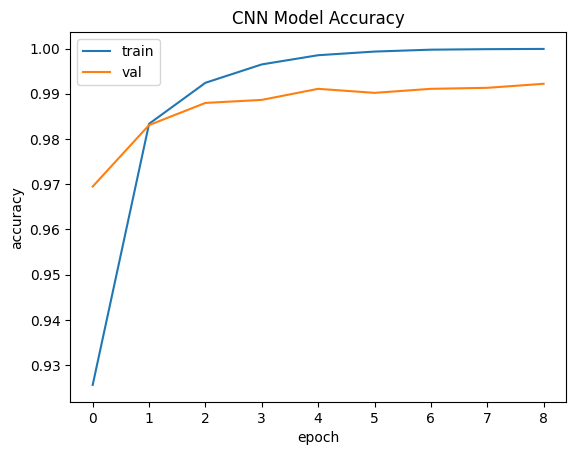

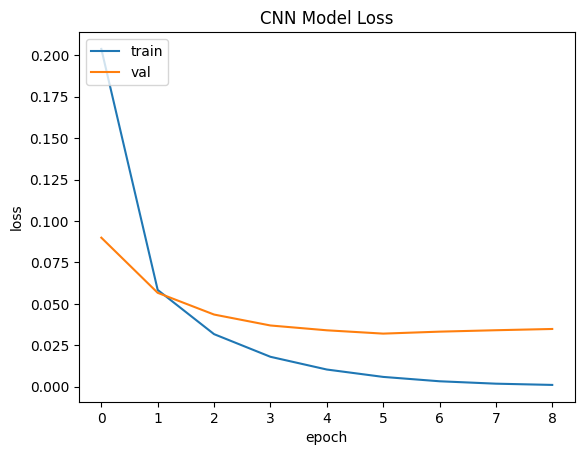

In [26]:
cnn_model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X_train_tfidf_arr = X_train_tfidf.toarray()
X_val_tfidf_arr = X_val_tfidf.toarray()

history = cnn_model.fit(X_train_tfidf_arr, y_train, epochs=10, batch_size=128, validation_data=(X_val_tfidf_arr, y_val), callbacks=[es])

#plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
X_test_tfidf_arr = X_test_tfidf.toarray()

test_loss, test_acc = cnn_model.evaluate(X_test_tfidf_arr, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.2f}')

141/141 - 18s - loss: 0.0380 - accuracy: 0.9875 - 18s/epoch - 130ms/step
Test accuracy: 0.99


# 7.Video presentation link

https://youtu.be/hPO3zO7hD7U